In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
leaderboard = {}

# Load the data
Load matrix and create list of samples and entries

In [84]:
df = pandas.read_csv("results/reannotated_allfusions_binmx.tsv", sep="\t", index_col=0)
df.columns = df.columns.map(lambda x:x.replace(".", "|"))
samples = list(set(i.split("|")[0] for i in df.columns if i not in ['fusion_key', 'fusion_id']))
entries = list(set(i.split("|")[1] for i in df.columns if i not in ['fusion_key', 'fusion_id']))
samples.remove("giab")
entries.remove("truth")

ValueError: list.remove(x): x not in list

In [4]:
def getConfMatrix(df, entries, sample, truth):
    o = {}
    for e in entries:
        k = "%s|%s" % (sample, e)
        if k in df:
            pos = df[df[k] > 0].index
            tp = sum(pos.isin(truth))
            fp = sum(~pos.isin(truth))
            fn = sum(~truth.isin(pos))
            o[e] = {'tp' : tp, 'fp' : fp, 'fn' : fn}
    return o

In [5]:
def f1Score(m):
    return (2.0 * (m['tp'])) / (2.0*m['tp'] + m['fp'] + m['fn'])

In [6]:
def tprScore(m):
    return (m['tp']) / (m['tp'] + m['fn'])

In [7]:
def fdrScore(m):
    return (m['fp']) / (m['fp'] + m['tp'])

# Create overall senstivity scores

In [8]:
tpr_data = {}
fdr_data = {}
f1_data = {}
count_data = {}
tp_data = {}
call_data = {}
for s in samples:
    td = {}
    fd = {}
    t = df[ df["%s|truth" % (s)] == 1 ].index
    res = getConfMatrix(df, entries, s, t)
    tpr_data[s] = dict( (a[0], tprScore(a[1])) for a in res.items() )
    fdr_data[s] = dict( (a[0], fdrScore(a[1])) for a in res.items() )
    f1_data[s] = dict( (a[0], f1Score(a[1])) for a in res.items() )
    tp_data[s] = dict( (a[0], a[1]['tp']) for a in res.items() )
    call_data[s] = dict( (a[0], a[1]['tp'] + a[1]['fp']) for a in res.items() )
    count_data[s] = len(t)
tpr_df = pandas.DataFrame(tpr_data)
fdr_df = pandas.DataFrame(fdr_data)
f1_df = pandas.DataFrame(f1_data)
tp_df = pandas.DataFrame(tp_data)
call_df = pandas.DataFrame(call_data)
spike_count = pandas.Series(count_data)

In [9]:
leaderboard['spike_tpr'] = tpr_df.sum(axis=1) / len(samples)

In [10]:
leaderboard['spike_fdr'] = fdr_df.sum(axis=1) / len(samples)

In [11]:
leaderboard['spike_f1'] = f1_df.sum(axis=1) / len(samples)

In [12]:
leaderboard['spike_call_count'] = call_df.sum(axis=1)

In [13]:
leaderboard['spike_tp_count'] = tp_df.sum(axis=1)

In [14]:
def entryColumns(a, df):
    c = []
    for b in samples:
        k = "%s|%s" % (b, a)
        if k in df.columns:
            c.append(k)
    return c

# Build correlation matrix between all entries

In [15]:
data = {}
for i in entries:
    for j in entries:
        a = df[entryColumns(i, df)].sum(axis=1)
        b = df[entryColumns(j, df)].sum(axis=1)
        c = a.corr(b)
        data[i] = {**data.get(i, {}), **{j:c}}
        data[j] = {**data.get(j, {}), **{i:c}}
corrDF = pandas.DataFrame(data)

In [16]:
workingEntries = corrDF.columns[ corrDF.apply(lambda x:x.isnull().sum(), axis=0) != corrDF.shape[0] ]

In [17]:
def thresholdGroup(distDF, threshold):
    groupMap = pandas.Series(dict((a[1], a[0]) for a in enumerate(distDF.columns)))
    while True:
        change = False
        for i in groupMap.index:
            t = distDF.columns[distDF[i] > threshold]
            for j in t:
                if j != i and groupMap[i] != groupMap[j]:
                    n = groupMap.copy()
                    n[n==groupMap[j]] = groupMap[i]
                    if not n.equals(groupMap):
                        change = True
                    groupMap = n
        if not change:
            break
    d = {}
    for i, j in groupMap.items():
        d[j] = d.get(j, []) + [i]
    return list(d.values())

In [18]:
clines = {}
for i in samples:
    if i != 'giab':
        t = i.split("_")
        cell = t[0]
        if len(t[1]) == 1 or t[1][1] == "A": # skip the technical replicates except for the one marked A
            if cell in clines:
                clines[cell].append(i)
            else:
                clines[cell] = [i]

In [19]:
true_sites = set()
for c in df.columns:
    if c.endswith("|truth"):
        true_sites.update(set(df[df[c] > 0][c].index))

In [20]:
def new_truth(df, sample, new_truth):
    k = "%s|truth" % (sample)
    orig_truth = (df[k][ df[k] == 1 ]).index
    return orig_truth.append(new_truth).unique()

In [21]:
data = {}
for s in samples:
    t = df[df["%s|truth" % (s)] == 1].index
    truthTP = pandas.Series(dict((a, b['tp']) for a,b in getConfMatrix(df, entries, s, t).items()))
    data[s] = (truthTP / spike_count[s])[entries]
truthRecall = pandas.DataFrame(data)

/mnt/home/ellrott/.local/lib/python3.6/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


# Build set of less-then-correlated methods, with recall rate of 0.6 or better

In [22]:
entryGroups = thresholdGroup(corrDF.reindex(columns=workingEntries, index=workingEntries), 0.9)
repSet = []
for i in entryGroups:
    scores = truthRecall.loc[i].mean(axis=1).sort_values(ascending=False)
    if scores[0] > 0.6:
        repSet.append(scores.index[0])

# For the representative set, what is the expected recall across all samples and all methods

In [23]:
truthRecall.loc[repSet].mean().mean()

0.7262345679012345

In [24]:
cellCombined = {}
cellSampleCount = {}
for c, e in clines.items():
    cols = list(b for b in ("%s|%s" % (a[0], a[1]) for a in itertools.product(e, repSet)) if b in df.columns)
    csum = df[cols].sum(axis=1)
    csum = csum[csum > 1][csum.index.difference(true_sites)].dropna()
    cellCombined[c] = csum
    cellSampleCount[c] = len(cols)

In [79]:
clines.values()

dict_values([['A549_3', 'A549_5', 'A549_4', 'A549_1', 'A549_2'], ['LNCapFGC_1', 'LNCapFGC_3', 'LNCapFGC_5', 'LNCapFGC_4', 'LNCapFGC_2'], ['JurkatI92_4', 'JurkatI92_3', 'JurkatI92_1', 'JurkatI92_5', 'JurkatI92_2'], ['HCC1143_5A1', 'HCC1143_1', 'HCC1143_2', 'HCC1143_4', 'HCC1143_3'], ['PC9_4', 'PC9_2', 'PC9_1', 'PC9_5', 'PC9_3'], ['PC3_3', 'PC3_2', 'PC3_4', 'PC3_5', 'PC3_1']])

## For a sample cell line, show number of histogram of consensus calls

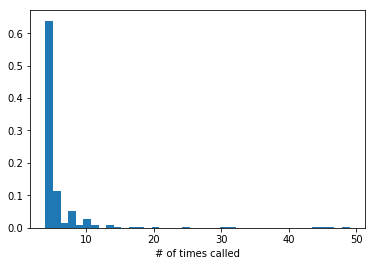

In [25]:
cellCombined['LNCapFGC'][ cellCombined['LNCapFGC'] > 3 ].hist(density=True, grid=False, bins=40)
_=plt.xlabel('# of times called')

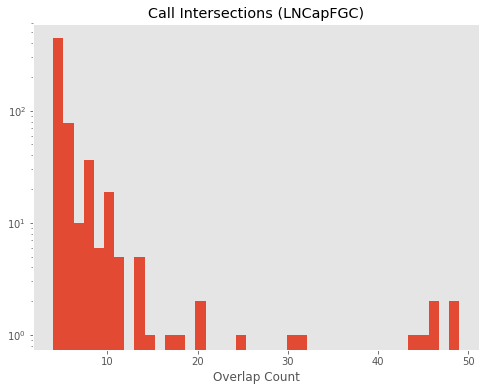

In [26]:
figSize=(8,6)
plt.figure(figsize=figSize)
plt.style.use('ggplot')
plt.title("Call Intersections (LNCapFGC)")
cellCombined['LNCapFGC'][ cellCombined['LNCapFGC'] > 3 ].hist(grid=False, bins=40, log=True)
_=plt.xlabel('Overlap Count')

## Example TPR projection using pseudo-truths for a single cell line

In [27]:
c = "LNCapFGC"
summary = {}
for l in clines[c]:
    o = {}
    for t in sorted(cellCombined[c].value_counts().index):
        new_sites = cellCombined[c][ cellCombined[c] >= t ].index
        nt = new_truth(df, l, new_sites)
        res = getConfMatrix(df, repSet, l, nt)
        o[t] = res
    summary[l] = o

## Evaluate one of the samples using the new iTruths

In [28]:
l = "LNCapFGC_1"
o = {}
for thres, data in summary[l].items():
    o[thres] = dict( (a[0], a[1]['tp'] / (a[1]['tp'] + a[1]['fn'])) for a in data.items() )
curveDF = pandas.DataFrame(o)

In [29]:
curveDF.loc[repSet]

,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,...,18.0,20.0,25.0,30.0,32.0,44.0,45.0,46.0,48.0,49.0
9610021,0.009864,0.042186,0.068038,0.156627,0.204188,0.327434,0.330097,0.492537,0.508197,0.738095,...,0.866667,0.896552,0.888889,0.884615,0.88,0.875000,0.869565,0.863636,0.85,0.842105
8396553,0.006138,0.026846,0.042722,0.108434,0.141361,0.238938,0.262136,0.388060,0.409836,0.595238,...,0.833333,0.827586,0.851852,0.884615,0.92,0.916667,0.913043,0.909091,0.90,0.894737
8644608,0.015783,0.060403,0.087025,0.188755,0.204188,0.327434,0.330097,0.492537,0.508197,0.738095,...,0.900000,0.931034,0.925926,0.923077,0.92,0.916667,0.913043,0.909091,0.90,0.894737
9609508,0.010741,0.044104,0.061709,0.144578,0.183246,0.292035,0.320388,0.477612,0.508197,0.738095,...,0.933333,0.931034,0.925926,0.923077,0.96,0.958333,0.956522,0.954545,0.95,0.947368
9609498,0.213941,0.304890,0.416139,0.550201,0.664921,0.672566,0.689320,0.731343,0.754098,0.666667,...,0.766667,0.758621,0.814815,0.846154,0.84,0.833333,0.826087,0.818182,0.80,0.789474
8040408,0.088777,0.164909,0.148734,0.192771,0.183246,0.265487,0.271845,0.417910,0.442623,0.642857,...,0.800000,0.827586,0.851852,0.884615,0.88,0.875000,0.869565,0.863636,0.85,0.842105
9610272,0.010741,0.046021,0.050633,0.124498,0.151832,0.256637,0.271845,0.402985,0.426230,0.619048,...,0.800000,0.827586,0.851852,0.884615,0.88,0.875000,0.869565,0.863636,0.85,0.842105
8399080,0.063130,0.092042,0.113924,0.152610,0.178010,0.274336,0.281553,0.417910,0.426230,0.619048,...,0.800000,0.827586,0.851852,0.884615,0.88,0.875000,0.869565,0.863636,0.85,0.842105
8517255,0.008110,0.035475,0.052215,0.128514,0.157068,0.247788,0.271845,0.402985,0.442623,0.642857,...,0.800000,0.793103,0.851852,0.846154,0.84,0.875000,0.869565,0.863636,0.85,0.842105
9609499,0.258220,0.398849,0.492089,0.614458,0.664921,0.654867,0.689320,0.731343,0.786885,0.714286,...,0.833333,0.827586,0.851852,0.846154,0.84,0.833333,0.826087,0.818182,0.80,0.789474


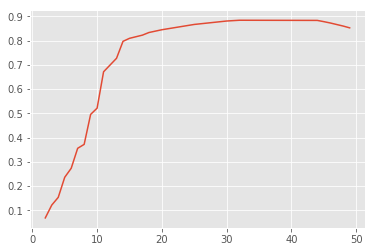

In [30]:
plt.plot(curveDF.loc[repSet].mean())

# Calculate TPR rate against iTruth (as determined by number of overlap sites) for all cell lines now

In [31]:
summary = {}
for c in clines:
    for l in clines[c]:
        o = {}
        for t in sorted(cellCombined[c].value_counts().index):
            new_sites = cellCombined[c][ cellCombined[c] >= t ].index
            nt = new_truth(df, l, new_sites)
            res = getConfMatrix(df, repSet, l, nt)
            o[t / cellSampleCount[c]] = pandas.Series( dict( (a[0], tprScore(a[1])) for a in res.items()) ).mean()
        summary[l] = o
        

In [32]:
sum(list( (cellCombined[c] >= 10).sum() for c in cellCombined)) 

289

Text(0, 0.5, 'TPR given psuedo truth')

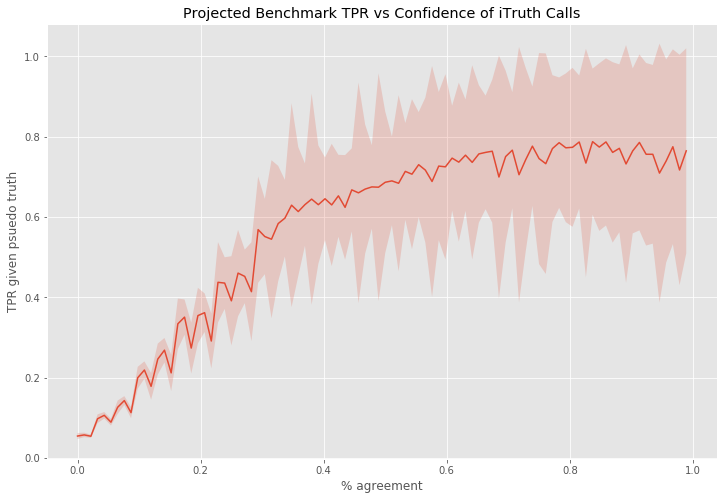

In [83]:
sumdf = pandas.DataFrame(summary)
x = np.arange(sumdf.shape[0]) / sumdf.shape[0]
ymean = sumdf.mean(axis=1)
yerr = sumdf.std(axis=1)

figSize=(12,8)
plt.figure(figsize=figSize)
plt.style.use('ggplot')
plt.plot(x, ymean)
plt.fill_between(x, ymean - yerr, ymean + yerr,
                alpha=0.2, )
plt.title("Projected Benchmark TPR vs Confidence of iTruth Calls")
plt.xlabel("% agreement")
plt.ylabel("TPR given psuedo truth")
#sumdf.mean(axis=1).plot(yerr=sumdf.std(axis=1))

In [34]:
print(sumdf.mean(axis=1).to_dict())

{0.04: 0.0549551751408465, 0.04081632653061224: 0.05774592623367031, 0.041666666666666664: 0.05442784626540972, 0.06: 0.09805197947773021, 0.061224489795918366: 0.10653500578240369, 0.0625: 0.08945868945868947, 0.08: 0.12654010947998034, 0.08163265306122448: 0.14323203087313072, 0.08333333333333333: 0.11321457120018272, 0.1: 0.2000593091107931, 0.10204081632653061: 0.21931404072883173, 0.10416666666666667: 0.17865649963689179, 0.12: 0.2465455626872005, 0.12244897959183673: 0.2687468290208016, 0.125: 0.21219589257503949, 0.14: 0.3343378231536036, 0.14285714285714285: 0.3510634920634921, 0.14583333333333334: 0.27398373983739843, 0.16: 0.35480450018173937, 0.16326530612244897: 0.3620885547201336, 0.16666666666666666: 0.29152263374485593, 0.18: 0.4377078421698822, 0.1836734693877551: 0.4357617411225658, 0.1875: 0.3915925925925926, 0.2: 0.4606139843950543, 0.20408163265306123: 0.4524053724053725, 0.20833333333333334: 0.4143621399176955, 0.22: 0.5688635421135421, 0.22448979591836735: 0.55165

# Do the same psuedo calculation for the known truth set, and plot TPR

In [35]:
data = {}
for l in samples:
    ts = df.loc[df["%s|truth" % (l)] == 1]
    osum = df[ df.columns.intersection( list("%s|%s" % (l, e) for e in repSet )) ].loc[df["%s|truth" % l] == 1].sum(axis=1)
    o = {}
    for t in sorted(osum.value_counts().index):
        if t > 1:
            nt = osum[ osum >= t ].index
            res = getConfMatrix(df, repSet, l, nt)
            o[t / len(repSet)] = dict( (a[0], a[1]['tp'] / (a[1]['tp'] + a[1]['fn'])) for a in res.items() )
    data[l] = pandas.DataFrame(o).mean()

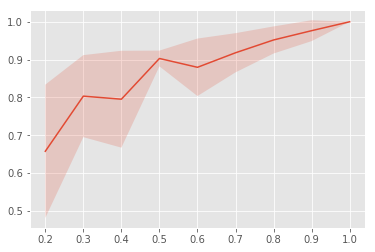

In [36]:
d = pandas.DataFrame(data).transpose()

ymean = d.mean()
yerr = d.std()

plt.plot(d.columns, ymean)
plt.fill_between(d.columns, ymean - yerr, ymean + yerr,
                alpha=0.2 )

# Create new 'iTruth' based on meta-calling and recalculate statistics

In [37]:
psuedoThresh = 0.5
pf1_data = {}
ptpr_data = {}
pfdr_data = {}
ptp_data = {}
for c in clines:
    t = cellSampleCount[c] * psuedoThresh
    new_sites = cellCombined[c][ cellCombined[c] >= t ].index
    print("%s pseudo truth sites: %d" % (c, len(new_sites)))
    print("\t" + "\n\t".join(new_sites))
    for l in clines[c]:
        nt = new_truth(df, l, new_sites)
        res = getConfMatrix(df, entries, l, nt)
        pf1_data[l] = pandas.Series( dict( (a[0], f1Score(a[1])) for a in res.items()) )
        ptpr_data[l] = pandas.Series( dict( (a[0], tprScore(a[1])) for a in res.items()) )
        pfdr_data[l] = pandas.Series( dict( (a[0], fdrScore(a[1])) for a in res.items()) )
        ptp_data[l] =  pandas.Series( dict( (a[0], a[1]['tp']) for a in res.items()) )
        

A549 pseudo truth sites: 4
	chr15_75137803_75137824_-_chr15_53998260_53998281_-
	chr3_172428626_172428647_-_chr3_124658350_124658371_-
	chr4_142610177_142610198_+_chr4_123536981_123537002_-
	chr5_39074202_39074223_-_chr5_39141232_39141253_-
LNCapFGC pseudo truth sites: 9
	chr10_86088550_86088571_+_chr10_96602583_96602604_+
	chr14_37969332_37969353_+_chr7_14188852_14188873_-
	chr17_7218267_7218288_-_chr17_41975737_41975758_-
	chr19_41223717_41223738_+_chr19_49637040_49637061_+
	chr1_8482776_8482797_-_chr1_9770471_9770492_+
	chr2_203500500_203500521_+_chr2_203329521_203329542_+
	chr4_142610177_142610198_+_chr4_123536981_123537002_-
	chr4_699748_699769_+_chr4_652730_652751_+
	chr6_158296197_158296218_+_chr10_96580242_96580263_+
JurkatI92 pseudo truth sites: 3
	chr14_19650115_19650136_+_chr14_19390855_19390876_+
	chr22_26040621_26040642_+_chr15_44216496_44216517_-
	chr4_142610177_142610198_+_chr4_123536981_123537002_-
HCC1143 pseudo truth sites: 13
	chr14_105886389_105886410_+_chr14_105172

In [49]:
for c in clines:
    t = cellSampleCount[c] * psuedoThresh
    new_sites = cellCombined[c][ cellCombined[c] >= t ].index
    print("%s out of %s" % (c, cellSampleCount[c]))
    print(cellCombined[c][ cellCombined[c] >= t ])

A549 out of 50
chr15_75137803_75137824_-_chr15_53998260_53998281_-      41.0
chr3_172428626_172428647_-_chr3_124658350_124658371_-    27.0
chr4_142610177_142610198_+_chr4_123536981_123537002_-    34.0
chr5_39074202_39074223_-_chr5_39141232_39141253_-        48.0
dtype: float64
LNCapFGC out of 50
chr10_86088550_86088571_+_chr10_96602583_96602604_+      46.0
chr14_37969332_37969353_+_chr7_14188852_14188873_-       45.0
chr17_7218267_7218288_-_chr17_41975737_41975758_-        48.0
chr19_41223717_41223738_+_chr19_49637040_49637061_+      25.0
chr1_8482776_8482797_-_chr1_9770471_9770492_+            49.0
chr2_203500500_203500521_+_chr2_203329521_203329542_+    44.0
chr4_142610177_142610198_+_chr4_123536981_123537002_-    30.0
chr4_699748_699769_+_chr4_652730_652751_+                32.0
chr6_158296197_158296218_+_chr10_96580242_96580263_+     46.0
dtype: float64
JurkatI92 out of 48
chr14_19650115_19650136_+_chr14_19390855_19390876_+      28.0
chr22_26040621_26040642_+_chr15_44216496_4421651

In [38]:
leaderboard["psuedo_f1"] = pandas.DataFrame(pf1_data).mean(axis=1)
leaderboard["psuedo_tpr"] = pandas.DataFrame(ptpr_data).mean(axis=1)
leaderboard["psuedo_fdr"] = pandas.DataFrame(pfdr_data).mean(axis=1)
leaderboard["psuedo_tp_count"] = pandas.DataFrame(ptp_data).sum(axis=1)

In [39]:
pandas.DataFrame(leaderboard).rank()

,spike_tpr,spike_fdr,spike_f1,spike_call_count,spike_tp_count,psuedo_f1,psuedo_tpr,psuedo_fdr,psuedo_tp_count
7269246,3.0,22.0,3.0,18.0,3.0,2.0,2.0,23.0,2.0
7488045,6.0,19.0,6.0,20.0,6.0,4.0,6.0,21.0,6.0
8040408,14.0,15.0,8.0,23.0,14.0,8.0,19.0,19.0,17.0
8071387,8.0,13.0,12.0,12.0,8.0,11.0,8.0,14.0,8.0
8114525,12.0,10.0,14.0,15.0,12.0,14.0,16.0,10.0,12.0
8226744,3.0,22.0,3.0,11.0,3.0,2.0,2.0,23.0,2.0
8281648,13.0,6.0,19.0,8.0,13.0,19.0,22.0,6.0,18.0
8396553,22.0,5.0,20.0,7.0,22.0,20.0,18.0,5.0,20.0
8399080,20.0,16.0,10.0,21.0,20.0,10.0,20.0,15.0,21.0
8517255,9.0,7.0,16.0,9.0,9.0,17.0,11.0,7.0,11.0


In [40]:
leadDF = pandas.DataFrame(leaderboard) 

In [41]:
c = ["tpr", "f1", "fdr"]
ave_data = {}
for a in c:    
    ave_data[ "ave_%s" % a ] = pandas.DataFrame( [ leadDF[ "spike_%s" % a ], leadDF[ "psuedo_%s" % a] ] ).mean()
aveDF = pandas.DataFrame(ave_data)

In [42]:
decending = ["spike_tpr", "spike_f1", "psuedo_tpr", "psuedo_f1"]
acending = ["spike_fdr", "psuedo_fdr"]
leadRankDF = leadDF[decending].join(1.0 - leadDF[acending]).rank(ascending=False).rename(columns=lambda x: x+"_rank")

In [43]:
leaderboard = leadDF.join(leadRankDF).join(aveDF).rename(columns=lambda x:"exon_" + x)

In [44]:
leaderboard.to_csv("fusion_leaderboard.tsv", sep="\t")

In [66]:
sampEnt = list(set(i for i in df.columns if i not in ['fusion_key', 'fusion_id']))
df[ df[ df.columns.to_series().filter(regex=r'truth$') ].sum(axis=1) > 0 ][sampEnt].sum(axis=1)

chr11_5275511_5275532_-_chr19_36034231_36034268_+        426
chr12_14840875_14840896_+_chr1_229567921_229567942_-     415
chr14_90867735_90867756_+_chr1_151374008_151374029_+     531
chr15_45003800_45003821_+_chr5_132010140_132010161_+     539
chr15_75017771_75017794_-_chr11_116707103_116707136_-    525
chr17_56316086_56316107_+_chr2_25384610_25384631_-       476
chr17_65362517_65362538_-_chr22_50928166_50928187_+      458
chr19_47735761_47735782_-_chr2_29072705_29072726_+       512
chr1_11907159_11907180_-_chr4_70822060_70822081_-        531
chr1_202888872_202888893_-_chr1_153946337_153946358_+    483
chr21_27542874_27542895_-_chr8_82195590_82195611_+       376
chr2_155555978_155555999_+_chr20_3596464_3596485_+       247
chr3_150780776_150780797_+_chr17_61995273_61995294_-     394
chr3_193311187_193311208_+_chr20_3063813_3063834_-       469
chr4_142610184_142610205_+_chr4_123536967_123536988_-     32
chr4_38126739_38126760_+_chr21_18937735_18937757_+       479
chr6_6266778_6266799_-_c

In [63]:
sampEnt = list(set(i for i in df.columns if i not in ['fusion_key', 'fusion_id']))

In [68]:
df[ df[ df.columns.to_series().filter(regex=r'truth$') ].sum(axis=1) > 0 ]

,A549_1|7269246,A549_1|7488045,A549_1|8040408,A549_1|8071387,A549_1|8114525,A549_1|8226744,A549_1|8281648,A549_1|8396553,A549_1|8399080,A549_1|8517255,...,PC3_3|truth,PC3_4|truth,PC3_5|truth,PC9_1|truth,PC9_2|truth,PC9_3|truth,PC9_4|truth,PC9_5|truth,fusion_key,fusion_id
chr11_5275511_5275532_-_chr19_36034231_36034268_+,0,0,1,0,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,HBG2>>GAPDHS,ENSG00000196565>>ENSG00000105679
chr12_14840875_14840896_+_chr1_229567921_229567942_-,0,0,0,0,1,0,1,1,1,0,...,1,1,1,1,1,1,1,1,RP11-174G6.1>>ACTA1,ENSG00000214772>>ENSG00000143632
chr14_90867735_90867756_+_chr1_151374008_151374029_+,0,0,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,CALM1>>PSMB4,ENSG00000198668>>ENSG00000159377
chr15_45003800_45003821_+_chr5_132010140_132010161_+,0,0,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,B2M>>IL4,ENSG00000166710>>ENSG00000113520
chr15_75017771_75017794_-_chr11_116707103_116707136_-,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,CYP1A1>>APOA1,ENSG00000140465>>ENSG00000118137
chr17_56316086_56316107_+_chr2_25384610_25384631_-,0,0,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,LPO>>POMC,ENSG00000167419>>ENSG00000115138
chr17_65362517_65362538_-_chr22_50928166_50928187_+,0,0,1,0,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,PSMD12>>MIOX,ENSG00000197170>>ENSG00000100253
chr19_47735761_47735782_-_chr2_29072705_29072726_+,0,0,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,BBC3>>SPDYA,ENSG00000105327>>ENSG00000163806
chr1_11907159_11907180_-_chr4_70822060_70822081_-,0,0,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,NPPA>>CSN2,ENSG00000175206>>ENSG00000135222
chr1_202888872_202888893_-_chr1_153946337_153946358_+,0,0,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,KLHL12>>CREB3L4,ENSG00000117153>>ENSG00000143578
